# Шаг I

скачиваем [item_views_dataset.tar.gz](https://cloud.mail.ru/public/nhpP/SyHmQQWnx)

Экспорт модулей

In [5]:
import os
import shutil
import tarfile

work_dir = '/home/jovyan/work'
parquet_dir_name = 'item_views'
extracted_data_path = os.path.join(work_dir, parquet_dir_name)

Распаковываем архив

In [7]:
if os.path.exists(extracted_data_path):
    print('Результирующая директория %s существует и будет удалена' % extracted_data_path)
    shutil.rmtree(extracted_data_path)

with tarfile.open('item_views_dataset.tar.gz') as archive:
    print('Распаковываем архив...:')
    archive.extractall(path=work_dir)
print('Данные извлечены в %s' % extracted_data_path)

Распаковываем архив...:
Данные извлечены в /home/jovyan/work/item_views


### Проверяем размер директории с файлами

In [8]:
!du -h 'item_views'

1.9G	item_views


In [9]:
os.listdir(extracted_data_path)[:10]

['part-00012-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00027-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00005-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00019-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00023-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00013-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00017-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00010-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00028-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet',
 'part-00021-83f339c2-28e6-4423-bb92-c2ab351df699-c000.snappy.parquet']

# Подключаем Spark

Создаём спарк-сессию

In [10]:
import pyspark

spark = (
    pyspark.sql.SparkSession.builder
    .master("local[*]")
    .getOrCreate()
)
print('спарк-сессия создана')

Почему спарк работает в Python, хотя он написан на Java?

In [11]:
os.environ['PYTHONPATH']

'/usr/local/spark/python:/usr/local/spark/python/lib/py4j-0.10.9-src.zip'

Читаем датасет из parquet

In [12]:
item_views_df = (
    spark.read
    .format('parquet')
    .load(extracted_data_path)
)

print('Количество строк в датасете', item_views_df.count())
item_views_df.show(5)

Количество строк в датасете 205564131
+-------+-------------------+
|content|          timestamp|
+-------+-------------------+
|  30436|2020-05-16 07:08:13|
|   8305|2020-05-09 07:03:05|
|  30203|2020-04-10 05:55:23|
|  21884|2020-03-25 12:57:34|
|  25396|2020-05-16 05:32:15|
+-------+-------------------+
only showing top 5 rows



### Переписываем в обычный csv

размер датасета возрастает в разы!

In [80]:
item_views_df.repartition(1).write.csv('item_views.csv', sep=',')

Мы получаем текстовый файл очень большого размера - в `pandas`, например, его не загрузишь. А вот Spark справляется "на ура". 

In [82]:
!du -h 'item_views.csv'

6.0G	item_views.csv


# EDA: строим график популярности контента

Добавляем колонку с днём месяца с помощью UDF, чтобы было проще агрегировать.

In [17]:
import datetime

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

udf_dt = udf(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'),StringType())
item_views_df = item_views_df.withColumn('dt', udf_dt('timestamp'))
item_views_df.show(5)

+-------+-------------------+----------+
|content|          timestamp|        dt|
+-------+-------------------+----------+
|  30436|2020-05-16 07:08:13|2020-05-16|
|   8305|2020-05-09 07:03:05|2020-05-09|
|  30203|2020-04-10 05:55:23|2020-04-10|
|  21884|2020-03-25 12:57:34|2020-03-25|
|  25396|2020-05-16 05:32:15|2020-05-16|
+-------+-------------------+----------+
only showing top 5 rows



In [18]:
%matplotlib inline

import pandas as pd

from pyspark.sql import DataFrame, functions as F

def agg_views_by_dt_for_content(df: DataFrame, content: int) -> DataFrame:
    result_df = (
        df
        .filter(F.col('content')==content)
        .groupBy('dt')
        .agg(F.count(F.lit(1)).alias('content_views'))
        .orderBy(F.col('dt').desc())
    ).toPandas()
    result_df['dt'] = pd.to_datetime(result_df['dt'])
    return result_df

Фильм появился на сервисе - видим органический рост "интереса" с нуля просмотров до N, затем выходим на плато

<AxesSubplot:title={'center':'Популярность контента id=5349'}, xlabel='dt'>

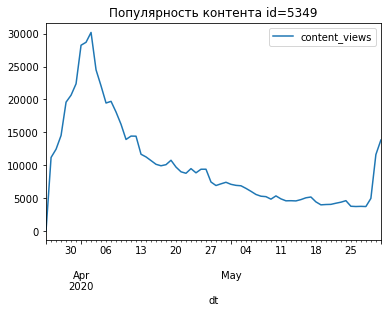

In [19]:
content_index = 5349  # Дело

(
    agg_views_by_dt_for_content(item_views_df, content_index)
    .plot(x='dt', y='content_views', title=f'Популярность контента id={content_index}')
)

Маша и медведь - в конце периода популярность начинает расти, т.к. каникулы

<AxesSubplot:title={'center':'Популярность контента id=720'}, xlabel='dt'>

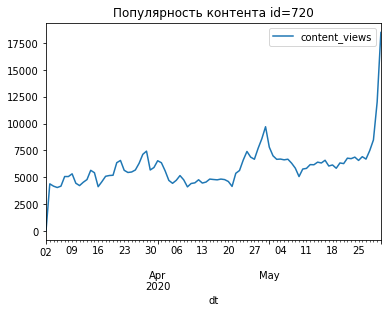

In [20]:
content_index = 720  # Маша и медведь - начинает расти, т.к. каникулы
(
    agg_views_by_dt_for_content(item_views_df, content_index)
    .plot(x='dt', y='content_views', title=f'Популярность контента id={content_index}')
)

"Алладин" - контент, популярность которого убывает с течением времени

<AxesSubplot:title={'center':'Популярность контента id=24639'}, xlabel='dt'>

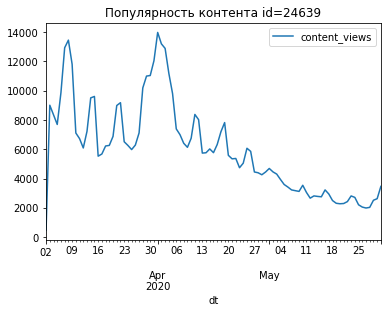

In [21]:
content_index = 24639 # Алладин
(
    agg_views_by_dt_for_content(item_views_df, content_index)
    .plot(x='dt', y='content_views', title=f'Популярность контента id={content_index}')
)

фильм Заражение является трендовым - его популярность была небольшой, затем последовал взлёт. Затем снова вернулось в "обычные" рамки

<AxesSubplot:title={'center':'Популярность контента id=10577'}, xlabel='dt'>

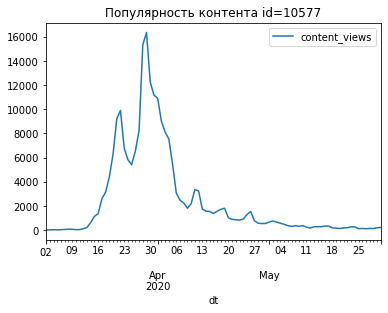

In [22]:
content_index = 10577  # фильм Заражение

(
    agg_views_by_dt_for_content(item_views_df, content_index)
    .plot(x='dt', y='content_views', title=f'Популярность контента id={content_index}')
)